In [1]:
# 필요 라이브러리 import
import os, sys
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [2]:
# 데이터 경로 및 SEED 설정
DATA_DIR = "resized_data_32"
SEED = 0xC0FFEE     # 12648430

# 재현성을 위한 시드 고정
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# 데이터 로드

In [3]:
# 정규화를 위한 train 데이터의 평균과 표준편차 계산

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="resized_data_32/train", transform=transform)

loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# 각 채널에 대한 합계와 제곱 합을 저장할 변수 초기화
mean = torch.zeros(3)
std = torch.zeros(3)
nimages = 0

for images, _ in loader:
    # 배치의 이미지 개수
    batch_samples = images.size(0)
    nimages += batch_samples

    # 채널별로 평균과 표준편차를 계산하기 위해 이미지의 크기를 변경
    images = images.view(batch_samples, images.size(1), -1)
    
    # 채널별 평균 계산
    mean += images.mean(2).sum(0)
    # 채널별 표준편차 계산
    std += images.std(2).sum(0)

# 전체 데이터셋에 대한 평균과 표준편차 계산
mean /= nimages
std /= nimages

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4538, 0.4784, 0.4104])
Std: tensor([0.1594, 0.1451, 0.1714])


In [7]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Resize(224),  # 긴 변을 224로 리사이즈
    transforms.Pad((224 - 32) // 2),  # 나머지를 패딩
    transforms.Resize((224, 224)),  # 224x224로 리사이즈
    transforms.RandomHorizontalFlip(),  # 50% 확률로 이미지 좌우 반전
    transforms.RandomVerticalFlip(),    # 50% 확률로 이미지 상하 반전
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize(224),  # Resize the long side to 224
    transforms.Pad((224 - 32) // 2),  # Padding the rest
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# ImageFolder를 사용하여 데이터셋 만들기
train_dataset = datasets.ImageFolder(root="resized_data_32/train", transform=transform)
valid_dataset = datasets.ImageFolder(root="resized_data_32/valid", transform=val_transform)

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

In [9]:
# 데이터 형태 확인
x, y = next(iter(train_loader))
print(x.shape, y.shape)

x, y = next(iter(validation_loader))
print(x.shape, y.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([32, 3, 224, 224]) torch.Size([32])


# Label 확인

In [5]:
classes = train_dataset.classes
print(classes)

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print(idx_to_class)

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
{0: 'Bacterial_spot', 1: 'Early_blight', 2: 'Late_blight', 3: 'Leaf_Mold', 4: 'Septoria_leaf_spot', 5: 'Spider_mites Two-spotted_spider_mite', 6: 'Target_Spot', 7: 'Tomato_Yellow_Leaf_Curl_Virus', 8: 'Tomato_mosaic_virus', 9: 'healthy', 10: 'powdery_mildew'}


In [11]:
len(classes)

11

# 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


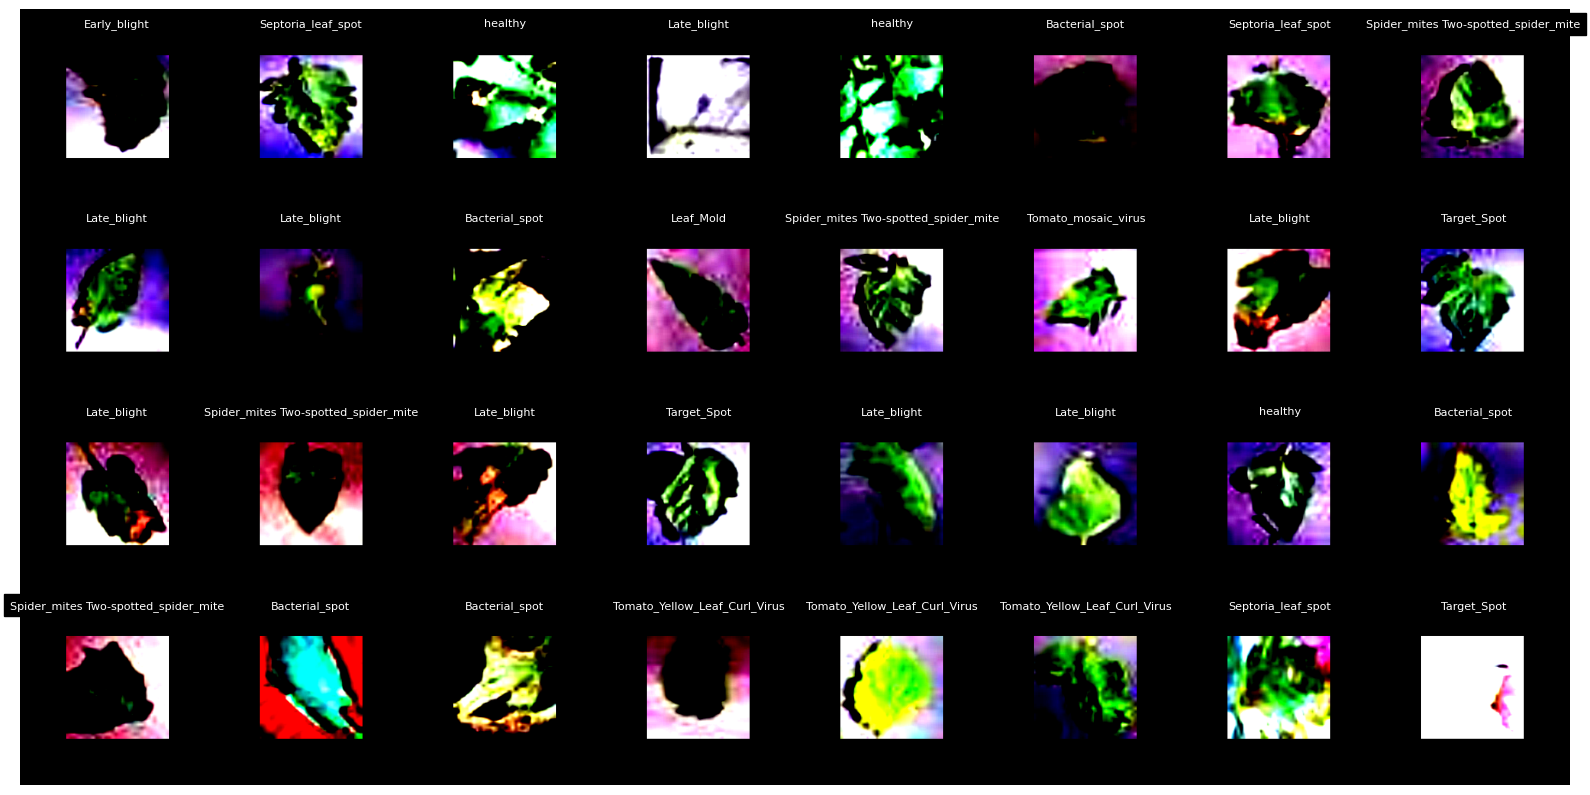

In [6]:
# 한 배치(32개)의 이미지 시각화 함수
def imshow(img, labels, classes):
    img = img.numpy().transpose((1, 2, 0))      # (C, H, W) -> (H, W, C)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    for i, label in enumerate(labels):
        x = (i % 8) * (img.shape[1] / 8) + (img.shape[1] / 16)      # 이미지의 x 좌표
        y = (i // 8) * (img.shape[0] / 4) + 10                      # 이미지의 y 좌표
        plt.text(       # 이미지 위에 라벨 표시
            x, y, classes[label], ha='center', va='top',
            color='white', fontsize=8, backgroundcolor='black'
        )
    plt.show()

# Data loader로부터 하나의 배치를 가져옴
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 그리드 만들기
img_grid = torchvision.utils.make_grid(images, nrow=8)      # 8개의 이미지를 한 줄로 나란히 이어붙임

# 이미지와 Label 시각화
imshow(img_grid, labels, classes)

# 모델 정의

In [9]:
# CUDA 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
import torchvision.models as models

class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        # ResNet-34 모델을 불러옵니다
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        
        # ResNet의 마지막 FC 레이어를 새로운 레이어로 교체합니다.
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.resnet(x)


In [11]:
model = ResNetModel(num_classes=len(classes)).to(device)

In [12]:
# 모델 확인
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [13]:
# 손실 함수와 최적화 함수 정의
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()     # 다중 클래스 분류 문제이므로 CrossEntropyLoss 사용

# 모델 훈련 및 검증

In [14]:
# 학습 함수 정의
def fit(model, data_loader, loss_fn, optimizer, device, phase='train'):
    # phase에 따라 모델의 모드 설정
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0

    # tqdm을 사용하여 반복문 진행 상황 시각화
    prograss_bar = tqdm(data_loader, leave=False)

    # mini-batch 단위 학습 시작
    for img, lbl in prograss_bar:
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()       # 누적 Gradient 초기화

        # Gradient 계산을 통한 Forward Propagation
        with torch.set_grad_enabled(phase == 'train'):
            pred = model(img)           # Forward Propagation 수행
            loss = loss_fn(pred, lbl)   # 손실 값 계산

            if phase == 'train':        # 학습 모드인 경우 Backward Propagation 및 가중치 업데이트 수행
                loss.backward()
                optimizer.step()

        pred = pred.argmax(1)           # pred의 확률값을 클래스 레이블로 변환
        running_loss += loss.item()     # 손실 값 누적
        running_corrects += torch.sum(pred == lbl.data)    # 정답 수 누적
    
    # 손실 값과 정확도 계산
    final_acc = running_corrects / len(data_loader.dataset)
    final_loss = running_loss / len(data_loader.dataset)

    return final_loss, final_acc

In [15]:
# Epoch별 모델 학습
num_epochs = 30

min_loss = np.inf
max_acc = 0.0

record_train_loss, record_train_acc = [], []
record_valid_loss, record_valid_acc = [], []

STATE_DICT_PATH = "temp_model.pth"

for epoch in range(num_epochs):
    start = time.time()

    # 학습 및 검증 단계 진행
    train_loss, train_acc = fit(
        model, train_loader, loss_fn, optimizer, device, phase='train'
    )
    valid_loss, valid_acc = fit(
        model, validation_loader, loss_fn, optimizer, device, phase='valid'
    )

    # 학습 결과 기록
    record_train_loss.append(train_loss)
    record_train_acc.append(train_acc)
    record_valid_loss.append(valid_loss)
    record_valid_acc.append(valid_acc)

    # 성능이 좋아질 경우 모델 저장
    if valid_loss < min_loss:
        print(
            f"[INFO] val_loss has been improved from {min_loss:.5f} to {valid_loss:.5f}. Saving Model!"
        )
        min_loss = valid_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)
    
    # 학습 시간 및 손실 값, 정확도 출력
    time_elapsed = time.time() - start
    print(
        f"[Epoch{epoch+1:02d}] time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s \t loss: {train_loss:.5f}, acc: {train_acc:.5f} | val_loss: {valid_loss:.5f}, val_acc: {valid_acc:.5f}"
    )

[INFO] val_loss has been improved from inf to 0.01505. Saving Model!
[Epoch01] time: 3m 56s 	 loss: 0.02390, acc: 0.74627 | val_loss: 0.01505, val_acc: 0.83813


[INFO] val_loss has been improved from 0.01505 to 0.01220. Saving Model!
[Epoch02] time: 3m 58s 	 loss: 0.01451, acc: 0.84419 | val_loss: 0.01220, val_acc: 0.86983


[INFO] val_loss has been improved from 0.01220 to 0.00885. Saving Model!
[Epoch03] time: 3m 54s 	 loss: 0.01113, acc: 0.87965 | val_loss: 0.00885, val_acc: 0.90352


[Epoch04] time: 3m 52s 	 loss: 0.00871, acc: 0.90750 | val_loss: 0.01016, val_acc: 0.89786


[INFO] val_loss has been improved from 0.00885 to 0.00811. Saving Model!
[Epoch05] time: 3m 53s 	 loss: 0.00766, acc: 0.91786 | val_loss: 0.00811, val_acc: 0.91485


[INFO] val_loss has been improved from 0.00811 to 0.00632. Saving Model!
[Epoch06] time: 3m 52s 	 loss: 0.00649, acc: 0.93061 | val_loss: 0.00632, val_acc: 0.93752


[Epoch07] time: 3m 53s 	 loss: 0.00557, acc: 0.94120 | val_loss: 0.00646, val_acc: 0.93706


[INFO] val_loss has been improved from 0.00632 to 0.00628. Saving Model!
[Epoch08] time: 3m 52s 	 loss: 0.00489, acc: 0.94849 | val_loss: 0.00628, val_acc: 0.93905


[INFO] val_loss has been improved from 0.00628 to 0.00561. Saving Model!
[Epoch09] time: 3m 52s 	 loss: 0.00430, acc: 0.95508 | val_loss: 0.00561, val_acc: 0.94992


[Epoch10] time: 3m 53s 	 loss: 0.00383, acc: 0.96136 | val_loss: 0.00577, val_acc: 0.94426


[Epoch11] time: 3m 52s 	 loss: 0.00344, acc: 0.96422 | val_loss: 0.00623, val_acc: 0.94395


[INFO] val_loss has been improved from 0.00561 to 0.00544. Saving Model!
[Epoch12] time: 3m 53s 	 loss: 0.00314, acc: 0.96701 | val_loss: 0.00544, val_acc: 0.95054


[INFO] val_loss has been improved from 0.00544 to 0.00542. Saving Model!
[Epoch13] time: 3m 53s 	 loss: 0.00287, acc: 0.97019 | val_loss: 0.00542, val_acc: 0.95467


[Epoch14] time: 3m 52s 	 loss: 0.00274, acc: 0.97223 | val_loss: 0.00577, val_acc: 0.94946


[Epoch15] time: 3m 53s 	 loss: 0.00238, acc: 0.97560 | val_loss: 0.00583, val_acc: 0.95145


[INFO] val_loss has been improved from 0.00542 to 0.00492. Saving Model!
[Epoch16] time: 3m 52s 	 loss: 0.00253, acc: 0.97313 | val_loss: 0.00492, val_acc: 0.95850


[Epoch17] time: 3m 56s 	 loss: 0.00201, acc: 0.98007 | val_loss: 0.00664, val_acc: 0.94701


[Epoch18] time: 3m 57s 	 loss: 0.00206, acc: 0.97839 | val_loss: 0.00746, val_acc: 0.93798


[Epoch19] time: 3m 51s 	 loss: 0.00201, acc: 0.98003 | val_loss: 0.00591, val_acc: 0.95329


[Epoch20] time: 3m 51s 	 loss: 0.00184, acc: 0.98097 | val_loss: 0.00498, val_acc: 0.96141


[Epoch21] time: 3m 51s 	 loss: 0.00170, acc: 0.98247 | val_loss: 0.00508, val_acc: 0.95942


[Epoch22] time: 3m 50s 	 loss: 0.00140, acc: 0.98670 | val_loss: 0.00548, val_acc: 0.95743


[INFO] val_loss has been improved from 0.00492 to 0.00474. Saving Model!
[Epoch23] time: 3m 50s 	 loss: 0.00159, acc: 0.98341 | val_loss: 0.00474, val_acc: 0.96493


[Epoch24] time: 3m 50s 	 loss: 0.00169, acc: 0.98254 | val_loss: 0.00564, val_acc: 0.95681


[Epoch25] time: 3m 50s 	 loss: 0.00145, acc: 0.98521 | val_loss: 0.00538, val_acc: 0.95865


[Epoch26] time: 3m 50s 	 loss: 0.00140, acc: 0.98556 | val_loss: 0.00560, val_acc: 0.95544


[Epoch27] time: 3m 50s 	 loss: 0.00136, acc: 0.98576 | val_loss: 0.00485, val_acc: 0.96309


[Epoch28] time: 3m 50s 	 loss: 0.00147, acc: 0.98415 | val_loss: 0.00518, val_acc: 0.96034


[Epoch29] time: 3m 50s 	 loss: 0.00106, acc: 0.98960 | val_loss: 0.00558, val_acc: 0.95881


[Epoch30] time: 3m 49s 	 loss: 0.00144, acc: 0.98552 | val_loss: 0.00495, val_acc: 0.95727


> 저장한 모델의 가중치 load

In [16]:
model.load_state_dict(torch.load("32_ResNet34.pth"))    # 가장 성능이 좋았던 모델 불러오기

<All keys matched successfully>

# 최종 예측 수행

In [17]:
predictons = []
model = model.to(device)
model.eval()

with torch.no_grad():
    running_loss = 0.0
    running_corrects = 0

    for img, lbl in validation_loader:
        img, lbl = img.to(device), lbl.to(device)

        pred = model(img)
        loss = loss_fn(pred, lbl)

        running_loss += loss.item()
        running_corrects += torch.sum(pred.argmax(1) == lbl.data)

        predictons.extend(pred.argmax(1).cpu().numpy())     # extend: 리스트에 다른 리스트의 요소를 추가할 때 사용

    # 손실 값과 정확도 계산
    final_acc = running_corrects / len(validation_loader.dataset)
    final_loss = running_loss / len(validation_loader.dataset)

In [18]:
# 결과 확인
print(f"<<Final Performances>>  Loss: {final_loss:.5f} | Accuracy: {final_acc:.5f}")
print(f"Prediction Length: {len(predictons)}  |  Prediction Example: {predictons[:15]}")

<<Final Performances>>  Loss: 0.00474 | Accuracy: 0.96493
Prediction Length: 6530  |  Prediction Example: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
# 예측 결과 확인
from sklearn.metrics import classification_report

y_true = [idx_to_class[i] for i in validation_loader.dataset.targets]
y_pred = [idx_to_class[i] for i in predictons]

print(classification_report(y_true, y_pred))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.97      0.96      0.97       732
                        Early_blight       0.96      0.93      0.95       642
                         Late_blight       0.95      0.96      0.96       724
                           Leaf_Mold       0.95      0.99      0.97       739
                  Septoria_leaf_spot       0.95      0.94      0.95       746
Spider_mites Two-spotted_spider_mite       0.96      0.96      0.96       435
                         Target_Spot       0.96      0.96      0.96       457
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.97      0.98       498
                 Tomato_mosaic_virus       0.98      0.98      0.98       584
                             healthy       0.98      0.98      0.98       721
                      powdery_mildew       0.97      0.97      0.97       252

                            accuracy                          

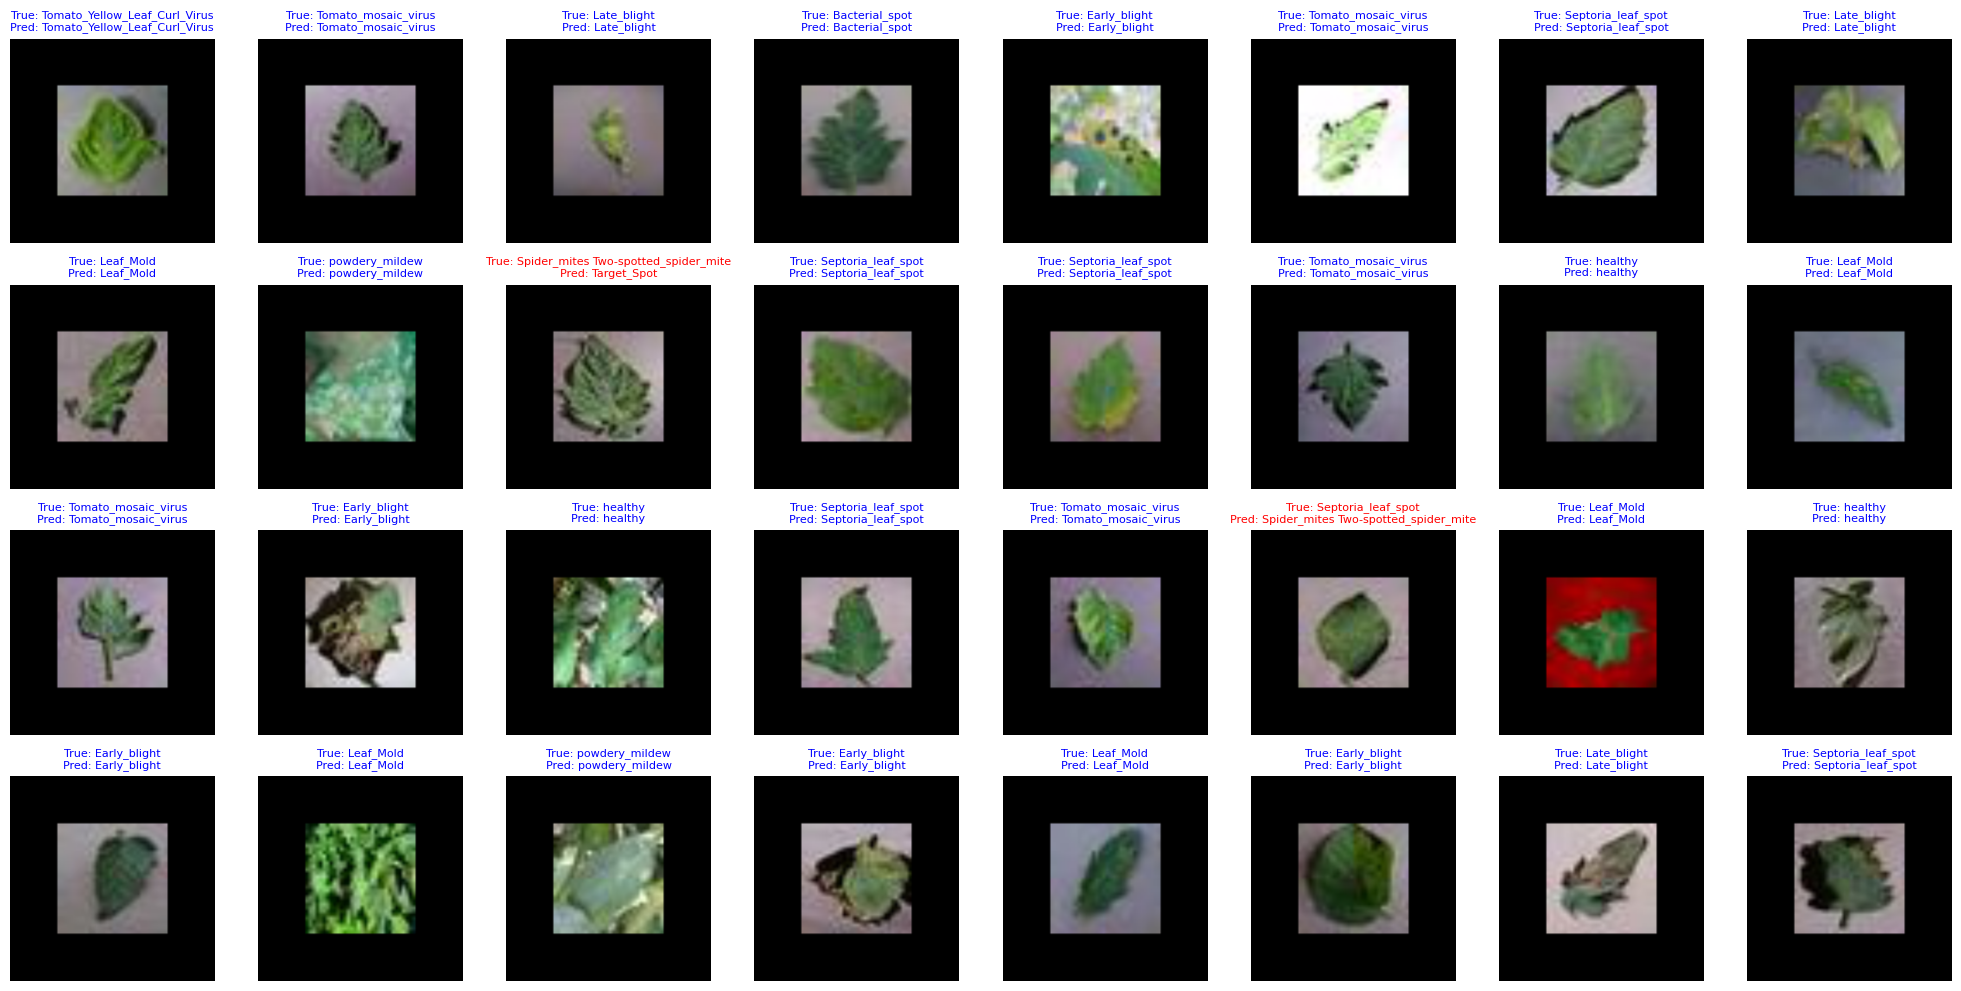

In [20]:
# 랜덤 샘플에 대한 예측 결과 시각화
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i in range(32):
    random_idx = random.randint(0, len(validation_loader.dataset))
    img, lbl = validation_loader.dataset[random_idx]

    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose((1, 2, 0))

    img = (img * std.numpy() + mean.numpy()).clip(0, 1)     # 이미지 정규화 해제    # clip: 최솟값과 최댓값을 지정하여 범위를 벗어나는 값을 잘라냄

    true_label = idx_to_class[lbl]
    pred_label = idx_to_class[predictons[random_idx]]

    ax = axes[i // 8, i % 8]
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
    # pred_label이 정답일 경우 font color를 파란색으로, 오답일 경우 빨간색으로 표시
    ax.title.set_color('blue' if true_label == pred_label else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()